# Milestone 5 - Applying Semantic Segmentation on Art images

---  

Image segmentation is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects). Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

The first section of this notebook will help you to familiarise yourself with the use of pre-trained segmentation models. Globally, these models tend to perform well but the segmentation can be improved by using additional art images. The second section will show how these pre-trained models can be refined.

> **Note 1:** During this milestone, only the `genre painting` images will be used. The scope reduction is intentional as we want you to focus on the understanding of the underlying concepts.

> **Note 2:** The content of this notebook is very similar to the previous notebooks you had to work on. We have kept the same structure to facilitate the comprehension.

  
## Objective of this notebook
* Applying Semantic Segmentation on images from Art Paintings dataset using pre-trained DeepLabV3 model to detect various object boundaries.
* Train pre-trained DeepLabv3 model using transfer learning on given art images dataset.

> **Note:** The content of this notebook follows the description provided in [Milestone-5](./Milestone-5.md)

---
## 1. Prerequisites

### Importing packages & modules

You might prefer to load the required modules/packages when required. Feel free to do so if it is your preference


In [1]:
# Common modules/packages
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
import sys, time
import warnings

# PyTorch modules/packages
import torch
import torch.nn

from PIL import Image, ImageFile
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

%matplotlib inline
warnings.filterwarnings('ignore')

### Setting up the training mode based on CUDA capability

In [2]:
device = 'cpu'  # sets the default value
train_on_gpu = torch.cuda.is_available()  # returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'

### Define some utilities functions  
These functions will be used to load the datasets

In [3]:
# Retrieves the list of files with a directory
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFoldersInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Calculates the Intersection Over Union (IOU)
def iou(pred, target, n_classes = 3):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
        if union > 0:
            ious.append(float(intersection) / float(max(union, 1)))

    return np.array(ious)

---
# SECTION 1 - PRE-TRAINED MODEL
---
## 1. Prepare the dataset

For the sake of simplicity, we will limit our input to the `genre painting` images. The set of images can found in the `segmented\genre` folder. It will be used as input to the models. In this section, the model will output the segmented images to the folder `segmented\outputs_s1`.

In [4]:
# DEFINE DATA DIRECTORIES & LOCATION OF IMAGE-SETS ARCHIVE
# --------------------------------------------------------

# sets the root folder for image sets
pathToDataset = pathlib.Path.cwd().joinpath('..','dataset')
pathToTest = pathToDataset.joinpath('test')

# Check 'segmented' folder exists
pathToSegmented = pathToDataset.joinpath('segmented')
if not pathToSegmented.exists():
    pathToSegmented.mkdir()

pathToSegmentedImg = pathToSegmented.joinpath('genre', 'train')
if not pathToSegmentedImg.exists():
    pathToSegmentedImg.mkdir()

pathToSegmentedOutput1 = pathToSegmented.joinpath('outputs_s1')
if not pathToSegmentedOutput1.exists():
    pathToSegmentedOutput1.mkdir()

## 2. Semantic Segmentation

`DeepLabV3 with Resnet-101 backbone` model will be used to deal with image semantic segmentation. This pre-trained model have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

The pre-trained model was trained on `21` classes and thus our output will have `21` channels ! We need to convert this 21 channeled outputs into a `2D` image (or a `1` channeled image), where each pixel of that image corresponds to a class.  

### 2.1. Segmentation Mapping
At some point, we will need to convert to a segmentation map an image where each pixel corresponds to a class label. Each class label will be converted into a `RGB` color. The purpose is to visualise easier the segmentation.

Let's define a function (called `decode_segmap`) that would accept an `2D` image and the colors for each categories handled by the model.

* The function should now create an `RGB` image from the `2D` image passed. To do so, the function creates empty `2D` matrices for all 3 channels. So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` (which is same as the shape of `image` passed in)
* The function will then loop over each class color we stored in `label_colors`, get the indexes in the image where that particular class label is present and  for each channel, it puts its corresponding color to those pixels where that class label is present.
* Finally the function stacks the 3 separate channels to form a `RGB` image.


In [31]:
def decode_segmap(image, label_colors):

    len_categories = len(label_colors)
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, len_categories):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

### 2.2. Image Pre-processing

The images should be preprocessed to facilitate the segmentation process. Let's define a function that will transform the images according to the model input expectations. 

* The function will first `label_colors` stores the colors for each of the classes, according to the index
    * The first class which is `background` is stored at the `0th` position (index)
    * The second class which is `aeroplane` is stored at the `1st` position (index)
    * ...

* Open the file and convert it to RGB  

* The function should unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]`  

* The `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label. So, each `(x, y)` will correspond to a number between `0 - 20` representing a class (`[1 x 21 x H x W]`). The function should take a max index for each pixel position.

> **Note:** The pre-trained model that will be used has been trained on `21 categories` (20 categories + background (black)).
> The classes that the pre-trained model outputs are the following, in order:  
>  ['__background__' , 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

> **Note:** The function will require a transformation which:  
>    * resize the image to `(256 x 256)`
>    * center and crop it to `(224 x 224)`
>    * convert it to a Tensor (all the values in the image becomes between `[0, 1]` from `[0, 255]`)
>    * normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

In [ ]:
# Define the data-augmentation transforms including normalisations
segment_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

label_colors = np.array([
              (0, 0, 0),  # 0=background
              (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),         # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
              (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),       # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
              (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128), # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
              (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
           ])



def segment(seg_model, fileName, outputPath, showImage=True):

    local_img = Image.open(fileName).convert('RGB')
    n_img = np.asarray(local_img)
    
    if len(n_img.shape) != 3:
        print('ERROR! ', file, ' is grayscale and not in RGB format. Cannot implement segmentation. Ignoring it!')
    else:
        print('Implementing segmentation on ', fileName)

        inp = segment_transforms(local_img).unsqueeze(0).to(device) # inp= Size([1, 3, 224, 224])
#        trans = transforms.ToPILImage(mode='RGB')
        out = seg_model.to(device)(inp)['out'] # out= Size([1, 21, 224, 224])
        image = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
        rgb = decode_segmap(image, label_colors)
        
        if (showImage == True):
            fig = plt.figure(figsize=(10, 10))
            plt.subplot(121)
            plt.imshow(local_img)
            plt.subplot(122)
            plt.imshow(rgb)
            plt.axis('off');
            plt.show()


### 2.3. Model-based Sematic Segmentation

1. Load in a pre-trained model & display its structure 
2. Process each file for each art category under `Test` folder, 


In [ ]:
# Set the model
deep_lab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Print out the model
#print( deep_lab )

# Collect the images
files = getFilesInDirectory(pathToSegmentedImg, '*.jpg')
for file in files:
    # Apply semantic segmentation
    segment(deep_lab, file, pathToSegmentedOutput1, showImage=False)

---
# SECTION 2 - TRANSFER LEARNING BASED ON PRE-TRAINED MODEL
---
The method used in Section 1 gives very good result considering that the pre-trained model has been trained through photographs. Let's see now if we can improve the performance by applying some transfer learning.

## 1. Data Preparation

For the sake of simplicity, we will limit our input to the `genre painting` images. The set of images can found in the `segmented\genre` folder which should have been created during Milestone 1. It will be used as input to the models. In this section, the model will require some ground truth masks - found under `segmented\masks`.

### 1.1. Customised Dataset

We will create a class representing a customised dataset (called `SegmentationDataset`) for image segmentation task in order to bundle data and functionality together. The class should extend the `Dataset` class (from `torch.utils.data.dataset`). It will contain the transformation definition for training and validation.

Three methods will be required:
* **__init__()**: should receive the path to the images and the ground truth masks and the mode (Training, Validation)
* **__len__()**: should return the number of the images
* **__getitem__**: should convert a combination of images and masks, transform the combination and return the image and the mask


In [5]:
import glob, os
from torch.utils.data.dataset import Dataset

class SegmentationDataset(Dataset):

    def __init__(self, img_path, mask_path, mode):
        super(SegmentationDataset, self).__init__()

        # Collect files
        self.img_files = glob.glob(os.path.join(img_path,'*.jpg'))
        self.msk_files = glob.glob(os.path.join(mask_path,'*.png'))

        # Data augmentation and normalization for training
        # Just normalization for validation (='V')
        if "V" == mode :
            self.transforms = transforms.Compose([
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
            ])
        else:
            self.transforms = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomCrop((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
                ])


    def __len__(self):
        return len(self.img_files)


    def __getitem__(self, index):
            img_path = self.img_files[index]
            msk_path = self.msk_files[index]

            image = Image.open(img_path)
            mask = Image.open(msk_path)

            # Convert to arrays
            image_np = np.asarray(image)
            mask_np = np.asarray(mask)
            
            # Convert to tuple (256, 256, 4)
            new_shape = (image_np.shape[0], image_np.shape[1], image_np.shape[2] + 1)
            
            # Convert to ndarray (256, 256, 4)
            combined_np = np.zeros(new_shape, image_np.dtype)
            
            # Concatenate image and mask so transformation is applied on both
            combined_np[:, :, 0:3] = image_np
            combined_np[:, :, 3] = mask_np

            # Convert to PIL
            combined = Image.fromarray(combined_np)

            # Apply transformation and get a Tensor [4, 224, 224]
            combined = self.transforms(combined)

            # Extract image Tensor ([3, 224, 224]) and mask Tensor ([1, 224, 224])
            image = combined[0:3, :, :]
            mask = combined[3, :, :].unsqueeze(0)
            
            # Normalize back from [0, 1] to [0, 255]
            mask = mask * 255

            #  Convert to int64 and remove second dimension - Tensor ([224, 224])
            mask = mask.long().squeeze()

            return image, mask

### 1.2. Path definition
Define the path to the Ground Truth masks. The path for images has already been defined.

In [6]:
# Masks folder
pathToSegmentedMask = pathToSegmented.joinpath('masks', 'train')
if not pathToSegmentedMask.exists():
    pathToSegmentedMask.mkdir()

### 1.3. Transformation & Data loaders
Some data loader's parameters will be set: the size of the batch to 4 and the number of workers to 0.

We will first instantiate the `SegmentationDataset` class with the appropriate parameters and, then, create a dataloader using the dataset instance.

**Note**: Don't forget to set to `True` the **drop_last** parameter of the Dataloader constructor. 

In [7]:
batch_size = 4
num_workers = 0

# 'T'rain & 'V'alidation transformations & data loaders
tv_datasets = {x: SegmentationDataset(pathToSegmentedImg, pathToSegmentedMask, x) for x in ['T', 'V']}
tv_dataloaders = {x: DataLoader(tv_datasets[x], batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers) for x in ['T', 'V']}


## 2. Modelling

Let's set the pretrained model based on which the transfer learning will be performed. Then we will set the different parameters of the features. The model will then be customized to fit specific requirements related to Semantic Segmentation. This is very similar to what we have seen in the previous milestones.

### 2.1. Load and configure the pre-trained model

In [8]:
# Set the number of output channels (= number of classes)
num_classes = 7

# Model definition
seg_model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)

# The auxiliary classifier is removed, and the pretrained weights are frozen
seg_model.aux_classifier = None
for param in seg_model.parameters():
    param.requires_grad = False

# The pretrained classifier is replaced by a new one with a custom number of classes.
# Since it comes after the freeze, its weights won't be frozen. They are the ones that we will fine-tune.
seg_model.classifier = DeepLabHead(2048, num_classes)

# Model serialisation
model_filename = 'custom_segmented.pt'
pathToModel = pathlib.Path.cwd().joinpath('..', 'models', model_filename)
print('File name for saved model: ', pathToModel)

# Loss function
criterion = torch.nn.CrossEntropyLoss() # combines nn.LogSoftmax() and nn.NLLLoss(), well suited for multiclass classification problems

# Optimizer definition
optimizer = torch.optim.SGD(seg_model.parameters(), lr=0.001, momentum=0.9)

# Use cpu/gpu based on availability
seg_model.to(device)

File name for saved model:  D:\Sources\GitHub\image-segmentation\Milestone 5\..\models\custom_segmented.pt


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 2.2. Setup variables used during Training & Validation

In [9]:
n_epochs = 50
counter = 0

# Initialise epoch performances
epoch_loss = 0.0
epoch_acc, epoch_bestacc = 0.0, 0.0

# Initialise training performances
train_iou_means, train_losses = [], []
train_loss, train_iou_mean = 0.0, 0.0

# Initialise validation performances
val_acc_history = []

### 2.3. Training & Validation

The structure of the Training & Validation phases has been simplified compared to the previous milestones.

**Training**  
The training will be performed by going through every epoch.  

* Set the `training` mode
* Collect a set of images and for each image:
    * activate the automated calculation of gradients
    * execute the model
    * calculate the loss using the criterion
    * apply a backward pass and single step optimization
    * collect the Intersection Over Union metric using the function defined at the beginning of this notebook

**Validate**  
The validation will be performed by going through every epoch - same as the training.

* Set the `evaluation` mode
* Place the model into validation model
    * execute the model
    * calculate the loss using the criterion
    * collect the Intersection Over Union metric using the function defined at the beginning of this notebook

Lastly, for each epoch, print the performance variables and save the model if the validation loss has decreased.


In [11]:
a = time.time()  # Start-time for training

for epoch in range(1, n_epochs+1):

    # Start-time for epoch
    c = time.time()

    for phase in ['T', 'V']:
        if phase == 'T':
            # Set to training mode
            seg_model.train()
        else:
            # Set to evaluation mode
            seg_model.eval()

        train_loss = 0.0
        train_iou_means = []
        
        # Iterate over data - Getting one batch of training images and their corresponding true labels
        for inputs, masks in tv_dataloaders[phase]:

            images = inputs.to(device) # Array of tensors - size: [3, 224, 224]
            masks = masks.to(device) #  Array of tensors - size: [224, 224]
 
            # zero the parameter gradients
            optimizer.zero_grad()

            # Turning on calculation of gradients (not required for validation)  {saves time}
            with torch.set_grad_enabled(phase == 'T'):
                
                outputs = seg_model(images)['out'] # returns an Array of tensors - size: [3, 224, 224]

                # Calculate the train loss
                train_criterion = criterion(outputs, masks)    # (prediction, true-label)
                train_loss += train_criterion.item() * inputs.size(0)

                # Returns the maximum values (tuple: values, indices) of each row of the `outputs` in the dimension `1`
                _, preds = torch.max(outputs, 1)

            if (phase == 'T'):
                
                # backward pass: compute gradient of the loss based on model parameters
                train_criterion.backward()

                # perform a single optimization step
                optimizer.step()

            # Collect the Intersection Over Union (IOU)
            train_iou_mean = iou(preds, masks, num_classes).mean()
            train_iou_means.append(train_iou_mean)
            train_losses.append(train_loss)

            # Increment counter
            counter = counter + 1

        # Displays statistics
        epoch_loss = train_loss / len(tv_dataloaders[phase].dataset)
        if (train_iou_means is not None):
            epoch_acc = np.array(train_iou_means).mean()
        else:
            epoch_acc = 0.

        d = time.time() # end-time for epoch

        print(f"Epoch: {epoch} | "
              f"Time: {int((d-c)/60)} min {int(d-c)%60} sec | "
              f"Phase: {phase} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}"
             )

        # save model if validation loss has decreased
        if ((phase == 'V') and (epoch_acc > epoch_bestacc)):
            print('Epoch accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(epoch_bestacc , epoch_acc))

            # saving model
            torch.save(seg_model.state_dict(), pathToModel)

            # update minimum validation loss
            epoch_bestacc = epoch_acc

        if (phase == 'V'):
            val_acc_history.append(epoch_acc)

################
# END OF EPOCH #
################
b = time.time()
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch: 1 | Time: 5 min 13 sec | Phase: T | Loss: 0.9506 | Acc: 0.0838
Epoch: 1 | Time: 6 min 52 sec | Phase: V | Loss: 1.3244 | Acc: 0.0849
Epoch accuracy increased (0.000000 --> 0.084945).  Saving model ...
Epoch: 2 | Time: 2 min 13 sec | Phase: T | Loss: 0.8055 | Acc: 0.1025
Epoch: 2 | Time: 3 min 51 sec | Phase: V | Loss: 1.0013 | Acc: 0.1176
Epoch accuracy increased (0.084945 --> 0.117569).  Saving model ...
Epoch: 3 | Time: 4 min 56 sec | Phase: T | Loss: 0.7525 | Acc: 0.1312
Epoch: 3 | Time: 6 min 38 sec | Phase: V | Loss: 0.8303 | Acc: 0.1229
Epoch accuracy increased (0.117569 --> 0.122931).  Saving model ...
Epoch: 4 | Time: 2 min 9 sec | Phase: T | Loss: 0.7369 | Acc: 0.1142
Epoch: 4 | Time: 3 min 39 sec | Phase: V | Loss: 0.7504 | Acc: 0.1252
Epoch accuracy increased (0.122931 --> 0.125220).  Saving model ...
Epoch: 5 | Time: 3 min 8 sec | Phase: T | Loss: 0.7147 | Acc: 0.1174
Epoch: 5 | Time: 6 min 40 sec | Phase: V | Loss: 0.7569 | Acc: 0.1529
Epoch accuracy increased (0.12

Epoch: 48 | Time: 3 min 40 sec | Phase: V | Loss: 0.5106 | Acc: 0.3823
Epoch: 49 | Time: 3 min 35 sec | Phase: T | Loss: 0.4217 | Acc: 0.3164
Epoch: 49 | Time: 5 min 26 sec | Phase: V | Loss: 0.4576 | Acc: 0.3823
Epoch: 50 | Time: 1 min 55 sec | Phase: T | Loss: 0.4286 | Acc: 0.3013
Epoch: 50 | Time: 3 min 27 sec | Phase: V | Loss: 0.4369 | Acc: 0.4047


	Total training time:  3 hour(s)  44 minute(s)  46 second(s)


3. Load the model  
The model saved has the lowest validation loss. It is that model that should be loaded.

In [12]:
seg_model.load_state_dict(torch.load(pathToModel))

<All keys matched successfully>

## 3. Testing

**Preparation**  

* The following variables will be defined:
    * The path where the test images are located
    * The transformation that will be applied on the test image


In [13]:
# Test & Valid image folder
pathToSegmentedTest = pathToSegmented.joinpath('genre', 'test')
if not pathToSegmentedTest.exists():
    pathToSegmentedTest.mkdir()

# Test transform & data loader
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the list of labels to be identified
label_colors = np.array([
            (0, 0, 0),  # 0= background
            (128, 0, 0), # 1= chair
            (0, 128, 0), # 2= door_window
            (128, 128, 0), # 3= person
            (0, 0, 128),  # 4= table
            (128, 0, 128), # 5= animal
            (0, 128, 128) # 6= bird
])

# Set the model to evaluate mode
seg_model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

**Testing**  

For each images present in the test folder:
* Convert the image to RGB
* Apply the transformation to the image and add a dimension to fit into the model input
* Execute the model
* Identify and colorise the segmented area based on `label_colors`
* Display the test image and the segmented mask produced by the model

Implementing segmentation on  D:\Sources\GitHub\image-segmentation\Milestone 5\..\dataset\segmented\genre\test\genre_052.jpg


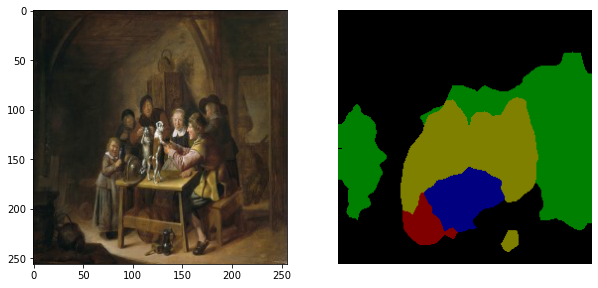

Implementing segmentation on  D:\Sources\GitHub\image-segmentation\Milestone 5\..\dataset\segmented\genre\test\genre_055.jpg


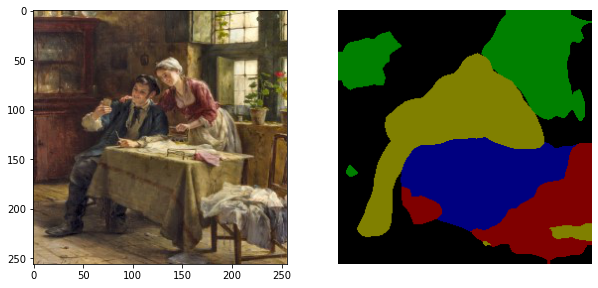

In [34]:
images = getFilesInDirectory(pathToSegmentedTest, '*.jpg')

for idx in range(0, len(images)-1):
    
    image_orig = Image.open(images[idx]).convert("RGB")
    n_img = np.asarray(image_orig)

    if len(n_img.shape) != 3:
        print('ERROR! ', file, ' is grayscale and not in RGB format. Cannot implement segmentation. Ignoring it!')
    else:
        print('Implementing segmentation on ', images[idx])

        # Apply the transformation to the image and add a dimension to fit into the model input
        inp = test_transforms(image_orig).unsqueeze(0).to(device) # inp= Size([1, 3, 256, 256])

        # Execute the model and return the output (`out`)
        out = seg_model.to(device)(inp)['out'] # out= Size([1, 7, 256, 256])
        
        # Returns the indices of the maximum values of a tensor across a dimension.
        image = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
        
        # Colorise the image with the predefined labels using the `decode_segmap`
        rgb = decode_segmap(image, label_colors)

        # Plotting
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(image_orig)
        plt.subplot(122)
        plt.imshow(rgb)
        plt.axis('off');
        plt.show()
